In [1]:
from datasets import load_dataset, get_dataset_config_names

get_dataset_config_names("cnn_dailymail")

['1.0.0', '2.0.0', '3.0.0']

In [2]:
dataset = load_dataset("cnn_dailymail", "3.0.0")
print(f"Features: {dataset['train'].column_names}")

Features: ['article', 'highlights', 'id']


In [3]:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length:{len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length:4051):

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


# Text Summarization Pipelines

In [4]:
sample_text = dataset["train"][1]["article"][:2000]
# We'll collect the generated summaries of each model in a dict
summaries = {}

In [5]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt_tab")

string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ssanchez/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


['The U.S. are a country.', 'The U.N. is an organization.']

## Summarization Baseline

In [6]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

summaries["baseline"] = three_sentence_summary(sample_text)

## GPT-2

To generate summaries by simply appending "TL;DR"(too long; didn't read) at the end of the input text

In [7]:
from transformers import pipeline, set_seed
import torch

set_seed(42)
pipe = pipeline("text-generation", model="gpt2-xl", device=0)
gpt2_query = sample_text + "\nTL;DR\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

/home/ssanchez/env/transformers/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/ssanchez/env/transformers/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feed

## T5

The developers of this model found they could create a universal transformer architecture by formulating all tasks as text-to-text tasks. The T5 checkpoints are trained on a mixture of unsupervised data (to reconstruct maked words) and supervised data for several tasks, including summarization.

These checkpoints can thus be directly used to perfrom summarization without fine-tuning by using the same prompts used during pretraining.

Summarize a document: *"summarize: <ARTICLE>"*.

Translation: "*translate English to German: <TEXT>*".

In [8]:
pipe = pipeline("summarization", model="t5-large", device=0)
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

## BART

Uses an encoder-decoder architecture and is trained to reconstruct corrupted inputs.

In [9]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn", device=0)
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

## PEGASUS

Encoder-decoder transformer. Its pretraining objective is to predict masked senteces in multisentence texts.

Authors argue that the closer is the pretraining objective is to the downstream task, the more effective it is. With the aim of finding a pretraining objective that is closer ro summarization than general language modeling, they automatically identified sentences containing most of the content of their surrounding paragraphs (using summarization evaluation metrics as a heristic for content overlap).

This model has a special token for newlines, which is why we don't need the *sent_tokenize()*

In [10]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail", device=0)
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

/home/ssanchez/env/transformers/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Comparing Different Summaries

GPT-2 has not been trained on the dataset at all. T5 has been fine-tuned on this task among others. BART and PEGASUS have exclusively been fine-tuned on this task.

In [11]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2
- The mentally ill incarcerated in Miami-Dade have no rights, except to be safe and locked in their cells until the court date arrives.
- As you'd expect, mental illness plays a major part in their arrests.
- The menta

# Measuring the Quality of Generated Text

## BLEU

The idea of BLEU is simple: instead of lookig at how many of the tokens in the generated texts are perectly aligned with the reference text tokens, we look at words or *n*-grams.

Is a precision-based metric, which means that when we compare the two texts we count the number of words in the generation that occur in the reference and divide it by the length of the reference.

A word is only counted as many times as it occurs in the reference. The occurrence count of an *n*-gram is capped at how many times it appears in the reference sentence.

The precision score favors the short generations -> *brevity penalty*

If we also measured recall we would incentivize translations that used all the words from all the references. Preferable to look for high precision in the translation and make sure the translation and reference have a similar length.

This metric has **many limitations**; synonims, derivation, it expects the text to already be tokenized --> **SacreBLEU** metric addresses this issue by internalizint the tokenization step.

In [12]:
import evaluate

bleu_metric = evaluate.load("sacrebleu")

In [13]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"]
)
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [14]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"]
)
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


The 1-grams in the prediction all match, and only in the precision scors do we see that something is off. The 4-gram there are only two candidates, where the last one does not match, hence the precision is 0.5.

There are other applications, such as summarization, where the situation is different. There, we want all the important information in the generated text, so we **favor high recall**.

## ROUGE

Developed for applications like summarization where high recall is more important than just precision.
Similar approach to the BLEU score. The difference is that ROUGE checks how many *n*-grams in the reference text also occur in the generated text. In BLEU we looked at how many n-grams in the generated text appear in the reference.

So we can reuse the precsion formula with the minor modification that we count the (unclipped) ocurrence of reference n-grams in the generated text in the numerator. Combine both precision and recall ROUGE scores in the harmonic mean to get an F1-score.

There is a separate score in ROUGE to measure the longest common substring (LCS) called ROUGE-L. Normalize the samples with the length of the reference and generated text, then the two normalized scores are mixed together.

ROUGE-L: calculates the score per sentence and averages it for the summaries.
ROUGE-Lsum: calculates the score directly over the whole summary.

In [15]:
rouge_metric = evaluate.load("rouge")

In [16]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name],
                    reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.290909,0.111111,0.181818,0.290909
t5,0.382979,0.130435,0.255319,0.382979
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.323232,0.206186,0.282828,0.323232


## Evaluating PEGASUS on the CNN/DailyMail Dataset

All the pieces to evaluate the model properly: dataset with a test set from CNN/DailyMail, metric with ROUGE and we have as summarization model.

In [17]:
def evaluate_summaries_baseline(dataset, metric,
                               column_text="article",
                               column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                    references=dataset[column_summary])
    score = metric.compute()
    return score

In [25]:
# Apply function to subset of the data
# Subset because every generated token requires a forward pass trough the model
test_sampled = dataset["test"].shuffle(seed=42).select(range(2000))

In [26]:
score = evaluate_summaries_baseline(test_sampled, rouge_metric)

In [27]:
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.388479,0.171775,0.243777,0.354232


In [21]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """Yield successice batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                              batch_size=16, device=device,
                              column_text="article",
                              column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches),
        total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024, truncation=True,
                          padding="max_length", return_tensors="pt")
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                                  attention_mask=inputs["attention_mask"].to(device),
                                  length_penalty=0.8, num_beams=8, max_length=128)
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True)
                            for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries,
                        references=target_batch)

        score = metric.compute()
        return score

In [22]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
                                  model, tokenizer, batch_size=8)

  0%|                                                                                                                                                                                                                             | 0/250 [00:03<?, ?it/s]


In [29]:
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.389936,0.149829,0.263226,0.321016


# Training a Summarization Model

SAMSum dataset developed by Samsung: collection of dialogues along with brief summaries.

In [36]:
dataset_samsum = load_dataset("nyamuda/samsum")
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

split lengths: [14732, 818, 819]
Features: ['id', 'summary', 'dialogue']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


## Evaluating PEGASUS on SAMSum

In [39]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(".<n>", ".\n"))

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [40]:
score = evaluate_summaries_pegasus(dataset_samsum["test"],
                                  rouge_metric, model, tokenizer,
                                  column_text="dialogue",
                                  column_summary="summary", batch_size=8)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

  0%|                                                                                                                                                                                                                             | 0/103 [00:03<?, ?it/s]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.267117,0.060507,0.196581,0.196891


## Fine-Tuning PEGASUS

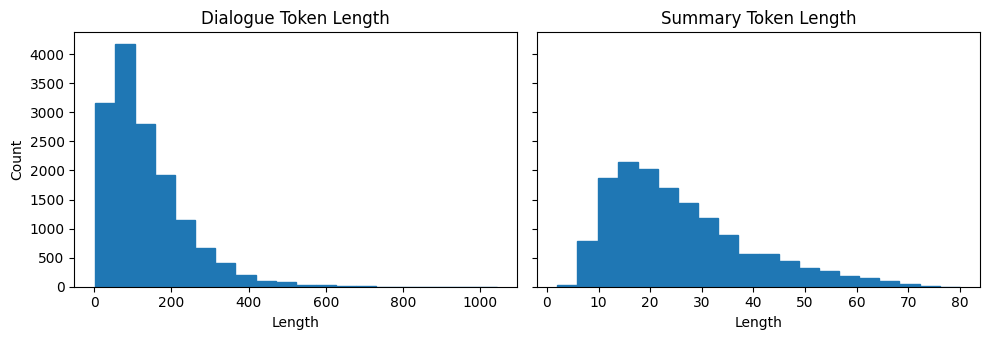

In [45]:
import matplotlib.pyplot as plt

d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [50]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024, truncation=True)
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128, truncation=True)
    return {"input_ids": input_encodings["input_ids"],
           "attention_mask": input_encodings["attention_mask"],
           "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/home/ssanchez/env/transformers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Some models require special tokens in the decoder inputs, that's why we use the *context manager* ***tokenizer.as_target_tokenizer()***

For summarization task we need to not only stack the inputs but also prepare the targets on the decoder side. In a seq2seq setup apply "teacher forcing" in the decoder: the decoder receives input tokens that consists of the labels shifted by one in addition to the encoder output. Shifting alone suffices since the decoder has masked self-attention. Set up the decoder inputs by shifting the labels to the right by one.

In [48]:
from transformers import DataCollatorForSeq2Seq, TrainingArguments, Trainer

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = TrainingArguments(
    output_dir="pegasus-samsum", num_train_epochs=1,
    warmup_steps=500, per_device_train_batch_size=1,
    per_device_eval_batch_size=1, weight_decay=0.01,
    logging_steps=10, push_to_hub=True,
    evaluation_strategy="steps", eval_steps=500,
    save_steps=1e6, gradient_accumulation_steps=16
)

/home/ssanchez/env/transformers/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [49]:
from huggingface_hub import notebook_login

notebook_login()

In [51]:
trainer = Trainer(model=model, args=training_args,
                 tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                 train_dataset=dataset_samsum_pt["train"],
                 eval_dataset=dataset_damsum_pt["validation"])

/tmp/ipykernel_1034089/2800926670.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

In [52]:
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid de

/home/ssanchez/env/transformers/lib/python3.8/site-packages/transformers/data/data_collator.py:657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss,Validation Loss
500,1.663400,1.480889


/home/ssanchez/env/transformers/lib/python3.8/site-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


AttributeError: 'Trainer' object has no attribute 'mocel'

In [56]:
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary"
)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

  0%|                                                                                                                                                                                                            | 0/410 [00:00<?, ?it/s]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.448718,0.266216,0.377289,0.377289


In [58]:
trainer.push_to_hub("Traoining complete!")

CommitInfo(commit_url='https://huggingface.co/sergi24sanchez/pegasus-samsum/commit/3a96159edd366d4ee45fae2a70f430e90e9cc5a2', commit_message='Traoining complete!', commit_description='', oid='3a96159edd366d4ee45fae2a70f430e90e9cc5a2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sergi24sanchez/pegasus-samsum', endpoint='https://huggingface.co', repo_type='model', repo_id='sergi24sanchez/pegasus-samsum'), pr_revision=None, pr_num=None)

## Generating Dialogue Summaries

It seems that the model is showing a significant improvement over the original model trained on CNN/DailyMail only.

In [59]:
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]

In [60]:
pipe = pipeline("summarization", model="sergi24sanchez/pegasus-samsum")
print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.3k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.60M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry. Amanda will text Larry.


In [61]:
# Custom input ???
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used the recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped built it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Thom, Lewis, Leandro and Lewis are going to write a book about transformers. Thom helped build a library by Hugging Face and Lewis used it recently.


# Conclusion

Text summarization poses some unique challenges compared to other tasks that can be framed as classification tasks, like sentiment analysis, named entity recognition or question answering.

Conventional metrics such as accuracy do not reflect the quality of the generated text. BLEU and ROUGE metrics can better evaluate generated texts; however, human judgement remains the best measure.

What happens if the texts to summarize are longer than the model's context length? Recent work by OpenAI showed how to scale summarization by applying it recursively to long documents and using human feedback in the loop.